In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, fbeta_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import multilabel_confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.preprocessing import MultiLabelBinarizer

import pandas as pd
import json
import os
import re   

import spacy
import matplotlib
import plotly.express as px
import plotly.subplots as sp
from plotly.subplots import make_subplots
from ast import literal_eval
from tqdm import tqdm

import sklearn.metrics
import numpy as np


In [2]:
data = '../src/rcatt_training_data_original.csv'

In [3]:
df = pd.read_csv(data).reset_index(drop = True)

In [4]:
df.iloc[: , :1] # visualise text column

,Text
0,Talos Blog || Cisco Talos Intelligence Group -...
1,OilRig Actors Provide a Glimpse into Developme...
2,Hogfish Redleaves Malware Threat Analysis I Ac...
3,Scheduled Transfer - Enterprise | MITRE ATT&CK...
4,Winlogon Helper DLL - Enterprise | MITRE ATT&C...
...,...
1485,"Xen - Wikipedia Xen From Wikipedia, the free e..."
1486,An Introduction to Hardware-Assisted Virtual M...
1487,virtualization.info | Debunking Blue Pill myth...
1488,Hypervisor - Wikipedia Hypervisor From Wikiped...


In [5]:
df = df[~df['Text'].duplicated()]

# Feature Extraction:

In [6]:
tf_idf = TfidfVectorizer(analyzer = 'word', stop_words='english', lowercase=True, min_df = 2, max_df = 0.99)

data = tf_idf.fit_transform(df['Text'])

X = pd.DataFrame(data.toarray(), columns=tf_idf.get_feature_names()) 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [11]:
Y = df[[col for col in df.columns if col.startswith('T') and col[1:].isdecimal()]]

In [12]:
Y

,T1066,T1047,T1156,T1113,T1067,T1037,T1033,T1003,T1129,T1492,...,T1124,T1035,T1086,T1490,T1216,T1094,T1043,T1211,T1127,T1077
0,1,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1486,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1487,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1488,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

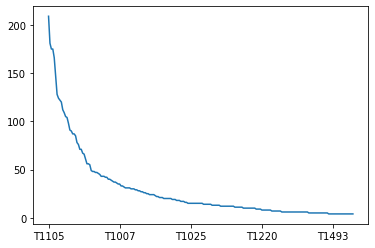

In [14]:
Y.sum(axis=0).sort_values(ascending=False).plot()

# Naive Bayes: 

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,
                                                    random_state = 10)

naive_bayes_classifier = OneVsRestClassifier(MultinomialNB())
naive_bayes_classifier.fit(x_train, y_train)


OneVsRestClassifier(estimator=MultinomialNB())

In [16]:
y_pred_proba = pd.DataFrame(naive_bayes_classifier.predict_proba(x_train), columns=y_train.columns)

In [17]:
y_pred = (y_pred_proba > 0.02).astype(int)

In [18]:
f_score_dict = {}
for col in y_test.columns:
    print(col)
    f_score_dict[col] = fbeta_score(y_train[col], y_pred[col],beta=0.5)
    print(classification_report(y_train[col], y_pred[col]))

T1066
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1016
           1       0.00      0.00      0.00        10

    accuracy                           0.99      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.98      0.99      0.99      1026

T1047


/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       984
           1       0.00      0.00      0.00        42

    accuracy                           0.96      1026
   macro avg       0.48      0.50      0.49      1026
weighted avg       0.92      0.96      0.94      1026

T1156
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1023
           1       0.00      0.00      0.00         3

    accuracy                           1.00      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      1.00      1.00      1026

T1113
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       956
           1       0.00      0.00      0.00        70

    accuracy                           0.93      1026
   macro avg       0.47      0.50      0.48      1026
weighted avg       0.87      0.93      0.90      1026

T1067
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       945
           1       0.75      0.04      0.07        81

    accuracy                           0.92      1026
   macro avg       0.84      0.52      0.52      1026
weighted avg       0.91      0.92      0.89      1026

T1129
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1023
           1       0.00      0.00      0.00         3

    accuracy                           1.00      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      1.00      1.00      1026

T1492
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1022
           1       0.00      0.00      0.00         4

    accuracy                           1.00      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      1.00      0.99      1026

T1044
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1015
           1       0.00      0.00      0.00        11

    accuracy                           0.99      1026
   macro avg       0.49      0.50      0.50      1026
weighted avg       0.98      0.99      0.98      1026

T1109
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1023
           1       0.00      0.00      0.00         3

    accuracy                           1.00      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      1.00      1.00      1026

T1099
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1005
           1       0.00      0.00      0.00        21

    accuracy                           0.98      1026
   macro avg       0.49      0.50      0.49      1026
weighted avg       0.96      0.98      0.97      1026

T1069
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1015
           1       0.00      0.00      0.00        11

    accuracy                           0.99      1026
   macro avg       0.49      0.50      0.50      1026
weighted avg       0.98      0.99      0.98      1026

T1178
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1019
           1       0.00      0.00      0.00         7

    accuracy                           0.99      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      0.99      0.99      1026

T1013
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1023
           1       0.00      0.00      0.00         3

    accuracy                           1.00      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      1.00      1.00      1026

T1192
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1014
           1       0.00      0.00      0.00        12

    accuracy                           0.99      1026
   macro avg       0.49      0.50      0.50      1026
weighted avg       0.98      0.99      0.98      1026

T1103
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1022
           1       0.00      0.00      0.00         4

    accuracy                           1.00      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      1.00      0.99      1026

T1007


/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1001
           1       0.00      0.00      0.00        25

    accuracy                           0.98      1026
   macro avg       0.49      0.50      0.49      1026
weighted avg       0.95      0.98      0.96      1026

T1040
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1017
           1       0.00      0.00      0.00         9

    accuracy                           0.99      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.98      0.99      0.99      1026

T1135
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1013
           1       0.00      0.00      0.00        13

    accuracy                           0.99      1026
   macro avg       0.49      0.50      0.50      1026
weighted avg       0.97      0.99      0.98      1026

T1120


/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1010
           1       0.00      0.00      0.00        16

    accuracy                           0.98      1026
   macro avg       0.49      0.50      0.50      1026
weighted avg       0.97      0.98      0.98      1026

T1082
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       904
           1       0.25      0.02      0.03       122

    accuracy                           0.88      1026
   macro avg       0.57      0.50      0.48      1026
weighted avg       0.81      0.88      0.83      1026

T1071
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       901
           1       0.50      0.04      0.07       125

    accuracy                           0.88      1026
   macro avg       0.69      0.52      0.50      1026
weighted avg       0.84      0.88      0.83      1026

T1053
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1022
           1       0.00      0.00      0.00         4

    accuracy                           1.00      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      1.00      0.99      1026

T1176
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1017
           1       0.00      0.00      0.00         9

    accuracy                           0.99      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.98      0.99      0.99      1026

T1106


/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1001
           1       0.00      0.00      0.00        25

    accuracy                           0.98      1026
   macro avg       0.49      0.50      0.49      1026
weighted avg       0.95      0.98      0.96      1026

T1058
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1024
           1       0.00      0.00      0.00         2

    accuracy                           1.00      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       1.00      1.00      1.00      1026

T1202
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1022
           1       0.00      0.00      0.00         4

    accuracy                           1.00      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      1.00      0.99      1026

T1024


/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       993
           1       0.00      0.00      0.00        33

    accuracy                           0.97      1026
   macro avg       0.48      0.50      0.49      1026
weighted avg       0.94      0.97      0.95      1026

T1091
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1013
           1       0.00      0.00      0.00        13

    accuracy                           0.99      1026
   macro avg       0.49      0.50      0.50      1026
weighted avg       0.97      0.99      0.98      1026

T1005
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       983
           1       1.00      0.02      0.05        43

    accuracy                           0.96      1026
   macro avg       0.98      0.51      0.51      1026
weighted avg       0.96      0.96      0.94      1026

T1140
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1019
           1       0.00      0.00      0.00         7

    accuracy                           0.99      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      0.99      0.99      1026

T1036
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       965
           1       0.33      0.02      0.03        61

    accuracy                           0.94      1026
   macro avg       0.64      0.51      0.50      1026
weighted avg       0.91      0.94      0.91      1026

T1055
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       962
           1       0.00      0.00      0.00        64

    accuracy                           0.94      1026
   macro avg       0.47      0.50      0.48      1026
weighted avg       0.88      0.94      0.91      1026

T1205
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1016
           1       0.00      0.00      0.00        10

    accuracy                           0.99      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.98      0.99      0.99      1026

T1032
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        54

    accuracy                           0.95      1026
   macro avg       0.47      0.50      0.49      1026
weighted avg       0.90      0.95      0.92      1026

T1062
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1021
           1       0.00      0.00      0.00         5

    accuracy                           1.00      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      1.00      0.99      1026

T1182
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1020
           1       0.00      0.00      0.00         6

    accuracy                           0.99      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      0.99      0.99      1026

T1004
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1014
           1       0.00      0.00      0.00        12

    accuracy                           0.99      1026
   macro avg       0.49      0.50      0.50      1026
weighted avg       0.98      0.99      0.98      1026

T1009
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1015
           1       0.00      0.00      0.00        11

    accuracy                           0.99      1026
   macro avg       0.49      0.50      0.50      1026
weighted avg       0.98      0.99      0.98      1026

T1076
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1022
           1       0.00      0.00      0.00         4

    accuracy                           1.00      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      1.00      0.99      1026

T1181
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1020
           1       0.00      0.00      0.00         6

    accuracy                           0.99      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      0.99      0.99      1026

T1483
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1015
           1       0.00      0.00      0.00        11

    accuracy                           0.99      1026
   macro avg       0.49      0.50      0.50      1026
weighted avg       0.98      0.99      0.98      1026

T1185
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1023
           1       0.00      0.00      0.00         3

    accuracy                           1.00      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      1.00      1.00      1026

T1217
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1024
           1       0.00      0.00      0.00         2

    accuracy                           1.00      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       1.00      1.00      1.00      1026

T1183
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1021
           1       0.00      0.00      0.00         5

    accuracy                           1.00      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      1.00      0.99      1026

T1085
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1022
           1       0.00      0.00      0.00         4

    accuracy                           1.00      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      1.00      0.99      1026

T1177
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1020
           1       0.00      0.00      0.00         6

    accuracy                           0.99      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      0.99      0.99      1026

T1125
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1008
           1       0.00      0.00      0.00        18

    accuracy                           0.98      1026
   macro avg       0.49      0.50      0.50      1026
weighted avg       0.97      0.98      0.97      1026

T1144
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1019
           1       0.00      0.00      0.00         7

    accuracy                           0.99      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      0.99      0.99      1026

T1070
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1003
           1       0.00      0.00      0.00        23

    accuracy                           0.98      1026
   macro avg       0.49      0.50      0.49      1026
weighted avg       0.96      0.98      0.97      1026

T1083
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       929
           1       0.25      0.01      0.02        97

    accuracy                           0.90      1026
   macro avg       0.58      0.50      0.48      1026
weighted avg       0.84      0.90      0.86      1026

T1138
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1019
           1       0.00      0.00      0.00         7

    accuracy                           0.99      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      0.99      0.99      1026

T1204
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       982
           1       0.00      0.00      0.00        44

    accuracy                           0.96      1026
   macro avg       0.48      0.50      0.49      1026
weighted avg       0.92      0.96      0.94      1026

T1196
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1022
           1       0.00      0.00      0.00         4

    accuracy                           1.00      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      1.00      0.99      1026

T1057
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1022
           1       0.00      0.00      0.00         4

    accuracy                           1.00      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      1.00      0.99      1026

T1015
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1009
           1       0.00      0.00      0.00        17

    accuracy                           0.98      1026
   macro avg       0.49      0.50      0.50      1026
weighted avg       0.97      0.98      0.98      1026

T1212
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1023
           1       0.00      0.00      0.00         3

    accuracy                           1.00      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      1.00      1.00      1026

T1210
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1017
           1       0.00      0.00      0.00         9

    accuracy                           0.99      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.98      0.99      0.99      1026

T1170
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1013
           1       0.00      0.00      0.00        13

    accuracy                           0.99      1026
   macro avg       0.49      0.50      0.50      1026
weighted avg       0.97      0.99      0.98      1026

T1048
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1011
           1       0.00      0.00      0.00        15

    accuracy                           0.99      1026
   macro avg       0.49      0.50      0.50      1026
weighted avg       0.97      0.99      0.98      1026

T1097
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1022
           1       0.00      0.00      0.00         4

    accuracy                           1.00      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      1.00      0.99      1026

T1078
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       996
           1       0.00      0.00      0.00        30

    accuracy                           0.97      1026
   macro avg       0.49      0.50      0.49      1026
weighted avg       0.94      0.97      0.96      1026

T1073
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1005
           1       0.00      0.00      0.00        21

    accuracy                           0.98      1026
   macro avg       0.49      0.50      0.49      1026
weighted avg       0.96      0.98      0.97      1026

T1068
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera


              precision    recall  f1-score   support

           0       0.87      0.99      0.93       891
           1       0.45      0.04      0.07       135

    accuracy                           0.87      1026
   macro avg       0.66      0.52      0.50      1026
weighted avg       0.82      0.87      0.82      1026

T1201


/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1019
           1       0.00      0.00      0.00         7

    accuracy                           0.99      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      0.99      0.99      1026

T1187
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1018
           1       0.00      0.00      0.00         8

    accuracy                           0.99      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.98      0.99      0.99      1026

T1486
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1013
           1       0.00      0.00      0.00        13

    accuracy                           0.99      1026
   macro avg       0.49      0.50      0.50      1026
weighted avg       0.97      0.99      0.98      1026

T1488


/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1023
           1       0.00      0.00      0.00         3

    accuracy                           1.00      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      1.00      1.00      1026

T1174
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1023
           1       0.00      0.00      0.00         3

    accuracy                           1.00      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      1.00      1.00      1026

T1002
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       992
           1       0.00      0.00      0.00        34

    accuracy                           0.97      1026
   macro avg       0.48      0.50      0.49      1026
weighted avg       0.93      0.97      0.95      1026

T1081
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       951
           1       0.00      0.00      0.00        75

    accuracy                           0.93      1026
   macro avg       0.46      0.50      0.48      1026
weighted avg       0.86      0.93      0.89      1026

T1203
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       992
           1       0.00      0.00      0.00        34

    accuracy                           0.97      1026
   macro avg       0.48      0.50      0.49      1026
weighted avg       0.93      0.97      0.95      1026

T1168
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1019
           1       0.00      0.00      0.00         7

    accuracy                           0.99      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      0.99      0.99      1026

T1100
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1022
           1       0.00      0.00      0.00         4

    accuracy                           1.00      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      1.00      0.99      1026

T1034
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1013
           1       0.00      0.00      0.00        13

    accuracy                           0.99      1026
   macro avg       0.49      0.50      0.50      1026
weighted avg       0.97      0.99      0.98      1026

T1499
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1011
           1       0.00      0.00      0.00        15

    accuracy                           0.99      1026
   macro avg       0.49      0.50      0.50      1026
weighted avg       0.97      0.99      0.98      1026

T1065
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1005
           1       0.00      0.00      0.00        21

    accuracy                           0.98      1026
   macro avg       0.49      0.50      0.49      1026
weighted avg       0.96      0.98      0.97      1026

T1498
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1016
           1       0.00      0.00      0.00        10

    accuracy                           0.99      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.98      0.99      0.99      1026

T1158


/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1015
           1       0.00      0.00      0.00        11

    accuracy                           0.99      1026
   macro avg       0.49      0.50      0.50      1026
weighted avg       0.98      0.99      0.98      1026

T1221
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1013
           1       0.00      0.00      0.00        13

    accuracy                           0.99      1026
   macro avg       0.49      0.50      0.50      1026
weighted avg       0.97      0.99      0.98      1026

T1134
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1009
           1       0.00      0.00      0.00        17

    accuracy                           0.98      1026
   macro avg       0.49      0.50      0.50      1026
weighted avg       0.97      0.98      0.98      1026

T1209
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1011
           1       0.00      0.00      0.00        15

    accuracy                           0.99      1026
   macro avg       0.49      0.50      0.50      1026
weighted avg       0.97      0.99      0.98      1026

T1052
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1020
           1       0.00      0.00      0.00         6

    accuracy                           0.99      1026
   macro avg       0.50      0.50      0.50      1026
weighted avg       0.99      0.99      0.99      1026

T1105
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       878
           1       0.38      0.03      0.06       148

    accuracy                           0.85      1026
   macro avg       0.62      0.51      0.49      1026
weighted avg       0.79      0.85      0.80      1026

T1084
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera


T1124
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1002
           1       0.00      0.00      0.00        24

    accuracy                           0.98      1026
   macro avg       0.49      0.50      0.49      1026
weighted avg       0.95      0.98      0.97      1026

T1035
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1007
           1       0.00      0.00      0.00        19

    accuracy                           0.98      1026
   macro avg       0.49      0.50      0.50      1026
weighted avg       0.96      0.98      0.97      1026

T1086
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       950
           1       0.00      0.00      0.00        76

    accuracy                           0.92      1026
   macro avg       0.46      0.50      0.48      1026
weighted avg       0.86      0.92      0.89      1026



/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [19]:
y_pred_proba = pd.DataFrame(naive_bayes_classifier.predict_proba(x_test), columns=y_test.columns)

In [20]:
y_pred = (y_pred_proba > 0.005).astype(int) # probability of report being part of the tactic

In [21]:
f_score_dict = {}
for col in y_test.columns:
    print(col)
    f_score_dict[col] = fbeta_score(y_test[col], y_pred[col],beta=0.5)
    print(classification_report(y_test[col], y_pred[col]))

T1066
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       438
           1       0.00      0.00      0.00         3

    accuracy                           0.99       441
   macro avg       0.50      0.50      0.50       441
weighted avg       0.99      0.99      0.99       441

T1047
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       422
           1       0.00      0.00      0.00        19

    accuracy                           0.95       441
   macro avg       0.48      0.50      0.49       441
weighted avg       0.92      0.95      0.93       441

T1156
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       440
           1       0.00      0.00      0.00         1

    accuracy                           1.00       441
   macro avg       0.50      0.50      0.50       441
weighted avg       1.00      1.00      1.00       441

T

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       436
           1       0.00      0.00      0.00         5

    accuracy                           0.99       441
   macro avg       0.49      0.50      0.50       441
weighted avg       0.98      0.99      0.98       441

T1037
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       438
           1       0.00      0.00      0.00         3

    accuracy                           0.99       441
   macro avg       0.50      0.50      0.50       441
weighted avg       0.99      0.99      0.99       441

T1033
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       415
           1       0.00      0.00      0.00        26

    accuracy                           0.93       441
   macro avg       0.47      0.50      0.48       441
weighted avg       0.89      0.93      0.91       441

T1003
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       440
           1       0.00      0.00      0.00         1

    accuracy                           1.00       441
   macro avg       0.50      0.50      0.50       441
weighted avg       1.00      1.00      1.00       441

T1044
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       440
           1       0.00      0.00      0.00         1

    accuracy                           1.00       441
   macro avg       0.50      0.50      0.50       441
weighted avg       1.00      1.00      1.00       441

T1171
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       437
           1       0.00      0.00      0.00         4

    accuracy                           0.99       441
   macro avg       0.50      0.50      0.50       441
weighted avg       0.98      0.99      0.99       441

T1014
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       435
           1       0.00      0.00      0.00         6

    accuracy                           0.99       441
   macro avg       0.49      0.50      0.50       441
weighted avg       0.97      0.99      0.98       441

T1114
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       439
           1       0.00      0.00      0.00         2

    accuracy                           1.00       441
   macro avg       0.50      0.50      0.50       441
weighted avg       0.99      1.00      0.99       441

T1163
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       440
           1       0.00      0.00      0.00         1

    accuracy                           1.00       441
   macro avg       0.50      0.50      0.50       441
weighted avg       1.00      1.00      1.00       441

T1025
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       439
           1       0.00      0.00      0.00         2

    accuracy                           1.00       441
   macro avg       0.50      0.50      0.50       441
weighted avg       0.99      1.00      0.99       441

T1063
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       425
           1       0.00      0.00      0.00        16

    accuracy                           0.96       441
   macro avg       0.48      0.50      0.49       441
weighted avg       0.93      0.96      0.94       441

T1080
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       438
           1       0.00      0.00      0.00         3

    accuracy                           0.99       441
   macro avg       0.50      0.50      0.50       441
weighted avg       0.99      0.99      0.99       441

T1167
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       434
           1       0.00      0.00      0.00         7

    accuracy                           0.98       441
   macro avg       0.49      0.50      0.50       441
weighted avg       0.97      0.98      0.98       441

T1120
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       437
           1       0.00      0.00      0.00         4

    accuracy                           0.99       441
   macro avg       0.50      0.50      0.50       441
weighted avg       0.98      0.99      0.99       441

T1082
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       388
           1       0.25      0.09      0.14        53

    accuracy                           0.86       441
   macro avg       0.57      0.53      0.53       441
weighted avg       0.81      0.86      0.83       441

T1071


/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       439
           1       0.00      0.00      0.00         2

    accuracy                           1.00       441
   macro avg       0.50      0.50      0.50       441
weighted avg       0.99      1.00      0.99       441

T1176
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       438
           1       0.00      0.00      0.00         3

    accuracy                           0.99       441
   macro avg       0.50      0.50      0.50       441
weighted avg       0.99      0.99      0.99       441

T1106
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       435
           1       0.00      0.00      0.00         6

    accuracy                           0.98       441
   macro avg       0.49      0.50      0.50       441
weighted avg       0.97      0.98      0.98       441

T1058
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       440
           1       0.00      0.00      0.00         1

    accuracy                           1.00       441
   macro avg       0.50      0.50      0.50       441
weighted avg       1.00      1.00      1.00       441

T1218
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       437
           1       0.00      0.00      0.00         4

    accuracy                           0.99       441
   macro avg       0.50      0.50      0.50       441
weighted avg       0.98      0.99      0.99       441

T1038
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       432
           1       0.00      0.00      0.00         9

    accuracy                           0.98       441
   macro avg       0.49      0.50      0.49       441
weighted avg       0.96      0.98      0.97       441

T1050
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       439
           1       0.00      0.00      0.00         2

    accuracy                           1.00       441
   macro avg       0.50      0.50      0.50       441
weighted avg       0.99      1.00      0.99       441

T1155
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       440
           1       0.00      0.00      0.00         1

    accuracy                           1.00       441
   macro avg       0.50      0.50      0.50       441
weighted avg       1.00      1.00      1.00       441

T1217
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       439
           1       0.00      0.00      0.00         2

    accuracy                           1.00       441
   macro avg       0.50      0.50      0.50       441
weighted avg       0.99      1.00      0.99       441

T1183
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       440
           1       0.00      0.00      0.00         1

    accuracy                           1.00       441
   macro avg       0.50      0.50      0.50       441
weighted avg       1.00      1.00      1.00       441

T1087
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       433
           1       0.00      0.00      0.00         8

    accuracy                           0.98       441
   macro avg       0.49      0.50      0.49       441
weighted avg       0.96      0.98      0.97       441

T1090
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       431
           1       0.00      0.00      0.00        10

    accuracy                           0.98       441
   macro avg       0.49      0.50      0.49       441
weighted avg       0.96      0.98      0.96       441

T1059
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera


T1041
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       435
           1       0.00      0.00      0.00         6

    accuracy                           0.98       441
   macro avg       0.49      0.50      0.50       441
weighted avg       0.97      0.98      0.98       441

T1060
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       400
           1       0.17      0.05      0.08        41

    accuracy                           0.89       441
   macro avg       0.54      0.51      0.51       441
weighted avg       0.84      0.89      0.86       441

T1023
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       430
           1       0.00      0.00      0.00        11

    accuracy                           0.97       441
   macro avg       0.49      0.50      0.49       441
weighted avg       0.95      0.97      0.96       441



/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       438
           1       0.00      0.00      0.00         3

    accuracy                           0.99       441
   macro avg       0.50      0.50      0.50       441
weighted avg       0.99      0.99      0.99       441

T1486
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       435
           1       0.00      0.00      0.00         6

    accuracy                           0.99       441
   macro avg       0.49      0.50      0.50       441
weighted avg       0.97      0.99      0.98       441

T1488
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       439
           1       0.00      0.00      0.00         2

    accuracy                           1.00       441
   macro avg       0.50      0.50      0.50       441
weighted avg       0.99      1.00      0.99       441

T1174
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       440
           1       0.00      0.00      0.00         1

    accuracy                           1.00       441
   macro avg       0.50      0.50      0.50       441
weighted avg       1.00      1.00      1.00       441

T1132
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       432
           1       0.00      0.00      0.00         9

    accuracy                           0.98       441
   macro avg       0.49      0.50      0.49       441
weighted avg       0.96      0.98      0.97       441

T1500
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       440
           1       0.00      0.00      0.00         1

    accuracy                           1.00       441
   macro avg       0.50      0.50      0.50       441
weighted avg       1.00      1.00      1.00       441

T1223
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [22]:
f_score_dict

{'T1066': 0.0,
 'T1047': 0.0,
 'T1156': 0.0,
 'T1113': 0.0,
 'T1067': 0.0,
 'T1037': 0.0,
 'T1033': 0.0,
 'T1003': 0.0,
 'T1129': 0.0,
 'T1492': 0.0,
 'T1044': 0.0,
 'T1171': 0.0,
 'T1014': 0.0,
 'T1501': 0.0,
 'T1123': 0.0,
 'T1133': 0.0,
 'T1109': 0.0,
 'T1099': 0.0,
 'T1069': 0.0,
 'T1114': 0.0,
 'T1163': 0.0,
 'T1025': 0.0,
 'T1116': 0.0,
 'T1093': 0.0,
 'T1178': 0.0,
 'T1013': 0.0,
 'T1192': 0.0,
 'T1489': 0.0,
 'T1206': 0.0,
 'T1063': 0.0,
 'T1080': 0.0,
 'T1167': 0.0,
 'T1165': 0.0,
 'T1137': 0.0,
 'T1089': 0.0,
 'T1487': 0.0,
 'T1214': 0.0,
 'T1119': 0.0,
 'T1115': 0.0,
 'T1103': 0.0,
 'T1007': 0.0,
 'T1040': 0.0,
 'T1135': 0.0,
 'T1120': 0.0,
 'T1082': 0.18796992481203006,
 'T1071': 0.07462686567164177,
 'T1053': 0.0,
 'T1162': 0.0,
 'T1176': 0.0,
 'T1106': 0.0,
 'T1058': 0.0,
 'T1202': 0.0,
 'T1024': 0.0,
 'T1091': 0.0,
 'T1005': 0.0,
 'T1140': 0.0,
 'T1195': 0.0,
 'T1190': 0.0,
 'T1219': 0.0,
 'T1079': 0.0,
 'T1036': 0.0,
 'T1055': 0.1282051282051282,
 'T1205': 0.0,
 'T1218'

In [23]:
np.mean(list(f_score_dict.values()))

0.005615091471845938

# SVM: 

In [24]:

sv_classifier = OneVsRestClassifier(LinearSVC(penalty = 'l2', loss = 'squared_hinge', dual = False, max_iter = 1000, class_weight = 'balanced', random_state=42), n_jobs = 1)
sv_classifier.fit(x_train, y_train)


OneVsRestClassifier(estimator=LinearSVC(class_weight='balanced', dual=False,
                                        random_state=42),
                    n_jobs=1)

In [25]:
y_pred = pd.DataFrame(sv_classifier.predict(x_train), columns=y_train.columns)

In [26]:
f_score_dict = {}
for col in y_test.columns:
    print(col)
    f_score_dict[col] = fbeta_score(y_train[col], y_pred[col],beta=0.5)
    print(classification_report(y_train[col], y_pred[col]))

T1066
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1016
           1       0.91      1.00      0.95        10

    accuracy                           1.00      1026
   macro avg       0.95      1.00      0.98      1026
weighted avg       1.00      1.00      1.00      1026

T1047
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       984
           1       0.81      1.00      0.89        42

    accuracy                           0.99      1026
   macro avg       0.90      0.99      0.94      1026
weighted avg       0.99      0.99      0.99      1026

T1156
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1023
           1       1.00      1.00      1.00         3

    accuracy                           1.00      1026
   macro avg       1.00      1.00      1.00      1026
weighted avg       1.00      1.00      1.00      1026

T

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1001
           1       0.96      1.00      0.98        25

    accuracy                           1.00      1026
   macro avg       0.98      1.00      0.99      1026
weighted avg       1.00      1.00      1.00      1026

T1040
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1017
           1       0.90      1.00      0.95         9

    accuracy                           1.00      1026
   macro avg       0.95      1.00      0.97      1026
weighted avg       1.00      1.00      1.00      1026

T1135
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1013
           1       1.00      1.00      1.00        13

    accuracy                           1.00      1026
   macro avg       1.00      1.00      1.00      1026
weighted avg       1.00      1.00      1.00      1026

T1120
 

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       926
           1       0.92      1.00      0.96       100

    accuracy                           0.99      1026
   macro avg       0.96      1.00      0.98      1026
weighted avg       0.99      0.99      0.99      1026

T1145
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1021
           1       1.00      1.00      1.00         5

    accuracy                           1.00      1026
   macro avg       1.00      1.00      1.00      1026
weighted avg       1.00      1.00      1.00      1026

T1112
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       976
           1       0.81      1.00      0.89        50

    accuracy                           0.99      1026
   macro avg       0.90      0.99      0.94      1026
weighted avg       0.99      0.99      0.99      1026

T1491
 

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       920
           1       0.85      1.00      0.92       106

    accuracy                           0.98      1026
   macro avg       0.92      0.99      0.95      1026
weighted avg       0.98      0.98      0.98      1026

T1023
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1006
           1       0.95      1.00      0.98        20

    accuracy                           1.00      1026
   macro avg       0.98      1.00      0.99      1026
weighted avg       1.00      1.00      1.00      1026

T1026
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1023
           1       1.00      1.00      1.00         3

    accuracy                           1.00      1026
   macro avg       1.00      1.00      1.00      1026
weighted avg       1.00      1.00      1.00      1026

T1122
 

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       992
           1       0.81      1.00      0.89        34

    accuracy                           0.99      1026
   macro avg       0.90      1.00      0.95      1026
weighted avg       0.99      0.99      0.99      1026

T1081
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1007
           1       0.59      1.00      0.75        19

    accuracy                           0.99      1026
   macro avg       0.80      0.99      0.87      1026
weighted avg       0.99      0.99      0.99      1026

T1128
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1023
           1       1.00      1.00      1.00         3

    accuracy                           1.00      1026
   macro avg       1.00      1.00      1.00      1026
weighted avg       1.00      1.00      1.00      1026

T1056
 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1010
           1       1.00      1.00      1.00        16

    accuracy                           1.00      1026
   macro avg       1.00      1.00      1.00      1026
weighted avg       1.00      1.00      1.00      1026

T1124
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1002
           1       1.00      1.00      1.00        24

    accuracy                           1.00      1026
   macro avg       1.00      1.00      1.00      1026
weighted avg       1.00      1.00      1.00      1026

T1035
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1007
           1       0.90      1.00      0.95        19

    accuracy                           1.00      1026
   macro avg       0.95      1.00      0.97      1026
weighted avg       1.00      1.00      1.00      1026

T1086
 

In [27]:
y_pred = pd.DataFrame(sv_classifier.predict(x_test), columns=y_test.columns)

In [28]:
f_score_dict = {}
for col in y_test.columns:
    print(col)
    f_score_dict[col] = fbeta_score(y_test[col], y_pred[col],beta=0.5)
    print(classification_report(y_test[col], y_pred[col]))

T1066
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       438
           1       1.00      0.33      0.50         3

    accuracy                           1.00       441
   macro avg       1.00      0.67      0.75       441
weighted avg       1.00      1.00      0.99       441

T1047
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       422
           1       0.22      0.11      0.14        19

    accuracy                           0.95       441
   macro avg       0.59      0.54      0.56       441
weighted avg       0.93      0.95      0.94       441

T1156
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       440
           1       0.00      0.00      0.00         1

    accuracy                           1.00       441
   macro avg       0.50      0.50      0.50       441
weighted avg       1.00      1.00      1.00       441

T

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       436
           1       0.50      0.40      0.44         5

    accuracy                           0.99       441
   macro avg       0.75      0.70      0.72       441
weighted avg       0.99      0.99      0.99       441

T1013
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       439
           1       0.00      0.00      0.00         2

    accuracy                           1.00       441
   macro avg       0.50      0.50      0.50       441
weighted avg       0.99      1.00      0.99       441

T1192
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       432
           1       0.12      0.11      0.12         9

    accuracy                           0.97       441
   macro avg       0.55      0.55      0.55       441
weighted avg       0.96      0.97      0.97       441

T1489
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       438
           1       0.22      0.67      0.33         3

    accuracy                           0.98       441
   macro avg       0.61      0.83      0.66       441
weighted avg       0.99      0.98      0.99       441

T1106
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       435
           1       0.00      0.00      0.00         6

    accuracy                           0.98       441
   macro avg       0.49      0.50      0.50       441
weighted avg       0.97      0.98      0.98       441

T1058
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       438
           1       0.00      0.00      0.00         3

    accuracy                           0.99       441
   macro avg       0.50      0.50      0.50       441
weighted avg       0.99      0.99      0.99       441

T1202
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       439
           1       0.00      0.00      0.00         2

    accuracy                           1.00       441
   macro avg       0.50      0.50      0.50       441
weighted avg       0.99      1.00      0.99       441

T1029
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       437
           1       0.00      0.00      0.00         4

    accuracy                           0.99       441
   macro avg       0.50      0.50      0.50       441
weighted avg       0.98      0.99      0.99       441

T1004
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       438
           1       0.00      0.00      0.00         3

    accuracy                           0.99       441
   macro avg       0.50      0.50      0.50       441
weighted avg       0.99      0.99      0.99       441

T1009
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       440
           1       0.00      0.00      0.00         1

    accuracy                           1.00       441
   macro avg       0.50      0.50      0.50       441
weighted avg       1.00      1.00      1.00       441

T1108
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       438
           1       0.00      0.00      0.00         3

    accuracy                           0.99       441
   macro avg       0.50      0.50      0.50       441
weighted avg       0.99      0.99      0.99       441

T1193
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       415
           1       0.44      0.27      0.33        26

    accuracy                           0.94       441
   macro avg       0.70      0.62      0.65       441
weighted avg       0.92      0.94      0.93       441

T1215
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       441

    accuracy                           1.00       441
   macro avg       1.00      1.00      1.00       441
weighted avg       1.00      1.00      1.00       441

T1480
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       438
           1       0.00      0.00      0.00         3

    accuracy                           0.99       441
   macro avg       0.50      0.50      0.50       441
weighted avg       0.99      0.99      0.99       441

T1204
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       414
           1       0.33      0.07      0.12        27

    accuracy                           0.93       441
   macro avg       0.64      0.53      0.54       441
weighted avg       0.91      0.93      0.91       441

T1196
              precision    recall  f1-score   support



/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera


T1208
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       439
           1       1.00      0.50      0.67         2

    accuracy                           1.00       441
   macro avg       1.00      0.75      0.83       441
weighted avg       1.00      1.00      1.00       441

T1027
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       395
           1       0.35      0.43      0.39        46

    accuracy                           0.86       441
   macro avg       0.64      0.67      0.65       441
weighted avg       0.87      0.86      0.86       441

T1201
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       440
           1       0.00      0.00      0.00         1

    accuracy                           1.00       441
   macro avg       0.50      0.50      0.50       441
weighted avg       1.00      1.00      1.00       441



/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       440
           1       0.00      0.00      0.00         1

    accuracy                           1.00       441
   macro avg       0.50      0.50      0.50       441
weighted avg       1.00      1.00      1.00       441

T1034
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       435
           1       1.00      0.17      0.29         6

    accuracy                           0.99       441
   macro avg       0.99      0.58      0.64       441
weighted avg       0.99      0.99      0.98       441

T1499
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       439
           1       0.50      1.00      0.67         2

    accuracy                           1.00       441
   macro avg       0.75      1.00      0.83       441
weighted avg       1.00      1.00      1.00       441

T1065
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor 

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       436
           1       1.00      0.20      0.33         5

    accuracy                           0.99       441
   macro avg       1.00      0.60      0.66       441
weighted avg       0.99      0.99      0.99       441

T1022
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       435
           1       0.07      0.17      0.10         6

    accuracy                           0.96       441
   macro avg       0.53      0.57      0.54       441
weighted avg       0.98      0.96      0.97       441

T1189
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       437
           1       0.00      0.00      0.00         4

    accuracy                           0.99       441
   macro avg       0.50      0.50      0.50       441
weighted avg       0.98      0.99      0.98       441

T1498
 

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [29]:
f_score_dict

{'T1066': 0.7142857142857143,
 'T1047': 0.18181818181818182,
 'T1156': 0.0,
 'T1113': 0.5241935483870968,
 'T1067': 0.3846153846153846,
 'T1037': 0.0,
 'T1033': 0.2941176470588236,
 'T1003': 0.3164556962025317,
 'T1129': 0.0,
 'T1492': 0.0,
 'T1044': 0.0,
 'T1171': 0.625,
 'T1014': 0.22727272727272727,
 'T1501': 0.0,
 'T1123': 0.43478260869565216,
 'T1133': 0.0,
 'T1109': 0.0,
 'T1099': 0.15625,
 'T1069': 0.0,
 'T1114': 0.8333333333333334,
 'T1163': 0.0,
 'T1025': 0.0,
 'T1116': 0.3448275862068966,
 'T1093': 0.0,
 'T1178': 0.47619047619047616,
 'T1013': 0.0,
 'T1192': 0.12195121951219513,
 'T1489': 0.7142857142857143,
 'T1206': 0.0,
 'T1063': 0.25,
 'T1080': 0.0,
 'T1167': 0.7142857142857143,
 'T1165': 0.0,
 'T1137': 0.9375,
 'T1089': 0.23809523809523808,
 'T1487': 1.0,
 'T1214': 0.0,
 'T1119': 0.5555555555555556,
 'T1115': 0.20833333333333331,
 'T1103': 0.0,
 'T1007': 0.3333333333333333,
 'T1040': 0.0,
 'T1135': 0.0,
 'T1120': 0.0,
 'T1082': 0.5447470817120622,
 'T1071': 0.54621848739

In [30]:
np.mean(list(f_score_dict.values()))

0.27594379342837105